In [40]:
%load_ext autoreload
%autoreload 2
import sys, os
import IPython.display as ipd
import torch
import numpy as np
import torchaudio

import librosa, librosa.display
import matplotlib.pyplot as plt

from fastai.vision.all import *
from fastai.data.all import *

from hparams import hp
from networks.speaker_embedder import SpeakerEmbedderGRU
from networks.ge2e_loss import GE2ELoss

device = torch.device('cuda')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data construction

In [2]:
class MelSpecGroup(tuple):
    ds_dirs = {
        'vctk': Path('PATH TO FOLDER OF PRECOMPUTED MEL-SPECTROGRAMS FOR VCTK DATASET'),
        'librispeech': Path('PATH TO FOLDER OF PRECOMPUTED MEL-SPECTROGRAMS FOR LIBRISPEECH DATASET'),
        'commonvoice': Path('PATH TO FOLDER OF PRECOMPUTED MEL-SPECTROGRAMS FOR THE COMMON VOICE DATASET'),
        'vcc': Path('PATH TO FOLDER OF PRECOMPUTED MEL-SPECTROGRAMS FOR VCC 2018 DATASET')
    }

    n_uttr = 6
    replace=True
    normalize = True
    min_log_value = -11.52
    
    @classmethod
    def normalize(cls, mspec):
        _normer = -cls.min_log_value/2
        return (mspec + _normer)/_normer
    
    @classmethod
    def denormalize(cls, mspec):
        _normer = -cls.min_log_value/2
        return (mspec*_normer) - _normer
    
    @classmethod
    def list_spk_names(cls):
        names = []
        for d in cls.ds_dirs: names.extend([s.name for s in cls.ds_dirs[d].iterdir() if s.is_dir()])
        return names
    
    @classmethod
    def create(cls, speaker_name):
        if 'ls' in speaker_name:
            dat_dir = cls.ds_dirs['librispeech']/speaker_name
        elif 'cv-' in speaker_name:
            dat_dir = cls.ds_dirs['commonvoice']/speaker_name
        elif 'VCC' in speaker_name:
            dat_dir = cls.ds_dirs['vcc']/speaker_name
        else:
            dat_dir = cls.ds_dirs['vctk']/speaker_name
        choice = np.random.choice(list(dat_dir.iterdir()), size=MelSpecGroup.n_uttr, replace=MelSpecGroup.replace)
        if choice[0].suffix == '.npy':
            mceps = [torch.from_numpy(np.load(str(o))).to(device) for o in choice] # each element is (n_mels=80, T)
        else:
            try:
                mceps = [torch.load(str(o), map_location=device) for o in choice]
            except Exception as e:
                print("Detected error as ", e, '[UNPICKLING ERROR]')
                print("Dumping files... ", choice)
        # We might want to normalize stuff here.... TODO
        for m in mceps:
            if m.numel() == 0 or len(m.shape) > 2:
                print('>>>>>>>>>> ', speaker_name)
                print("Reading files ", choice)
                raise AssertionError()

        return cls(tuple(TensorImage(m) for m in mceps))
    
def MelSpecBlock(): 
    return TransformBlock(type_tfms  = MelSpecGroup.create, item_tfms=[])

In [3]:
spk_names = MelSpecGroup.list_spk_names()
print(len(spk_names))

18067


In [4]:
dblock = DataBlock(
    blocks    = (MelSpecBlock, CategoryBlock(vocab=spk_names)),
#     get_items = lambda x: (x, x), 
#     get_x     = lambda t : t[0],
#     get_y     = lambda t : t[1])
    splitter  = RandomSplitter(valid_pct=0.05, seed=6))

In [5]:
sample_length_min = 96#128
sample_length_max = 288#312

def _trim_pad_mceps(mceps, required_length, pad_mode='constant'):
    """ Pads or trims each mcep in `mceps` to be `required_length`. A trim is randomly sampled, a pad is done with `pad_mode`"""
    rrers = []
    for m in mceps:
        if m.shape[-1] < required_length:
            pad_num = max(required_length - m.shape[-1], 0)
            num_pad_left = pad_num // 2
            num_pad_right = pad_num - num_pad_left
            if pad_mode == 'constant':
                k = F.pad(m[None], (num_pad_left, num_pad_right), mode=pad_mode, value=m.min())[0]
            else:
                k = F.pad(m[None], (num_pad_left, num_pad_right), mode=pad_mode)[0]
            rrers.append(k)
        else:
            s = torch.randint(0, int(m.shape[-1] - required_length + 1), (1, ))
            rrers.append(m[:, s:s+required_length])
    return MelSpecGroup(tuple(rrers))
            

def create_batch(data):
    batch_len = torch.randint(sample_length_min, sample_length_max+1, (1, ))
    xs, ys = [], []
    for d in data:
        xs.append(torch.stack(_trim_pad_mceps(d[0], batch_len, pad_mode='constant'), dim=0))
        ys.append(d[1])
    xs = torch.stack(xs, dim=0)
    
    ## HERE IS WHERE WE NORMALIZE
    if MelSpecGroup.normalize:
        xs = MelSpecGroup.normalize(xs)
    
    ys = torch.stack(ys, dim=0)
    return TensorBase(xs), TensorCategory(ys) # batch x is now (bs, n_uttr, n_mels, T_batch)

In [7]:
dls = dblock.dataloaders(spk_names, bs=8, verbose=False, create_batch=create_batch , num_workers=0, device=device)

In [8]:
def ge2e_show_batch(max_n=3):
    xb, yb = dls.one_batch()
    fig, axes = plt.subplots(ncols=MelSpecGroup.n_uttr, nrows=max_n, figsize=(20,6))
    for i in range(max_n):
        xs, ys = xb[i], yb[i]
        for j, x in enumerate(xs):
            librosa.display.specshow(x.cpu().numpy(), y_axis='mel', cmap='viridis', ax=axes[i,j])
            axes[i,j].set_title(dls.vocab[ys])
            axes[i,j].axis('off')

In [9]:
xb, yb = dls.one_batch()
xb.max(), xb.min()

(TensorBase(1.3233, device='cuda:0'), TensorBase(-0.9988, device='cuda:0'))

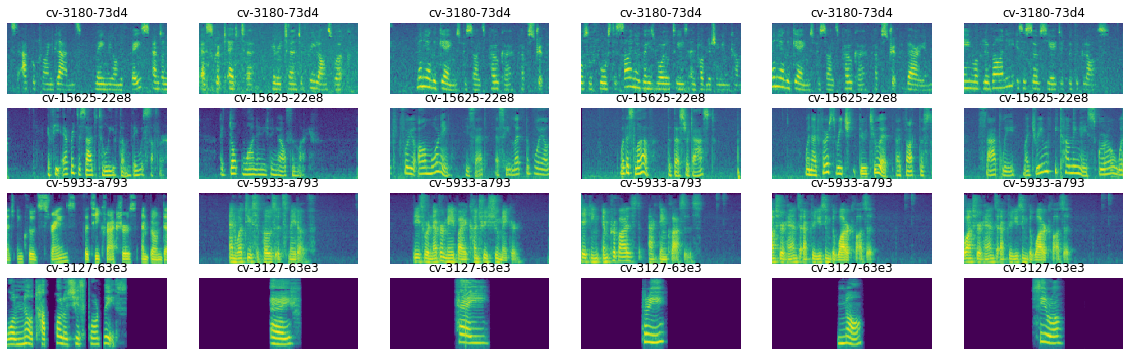

In [42]:
ge2e_show_batch(4)

# Model and loss definition

In [10]:
xx, yy = dls.one_batch()
xx.max(), xx.min()

(TensorBase(1.2497, device='cuda:0'), TensorBase(-0.9988, device='cuda:0'))

In [11]:
class GradClip(Callback):
    def after_backward(self): 
        nn.utils.clip_grad_norm_(self.learn.model.encoder.parameters(), 3.0)
        nn.utils.clip_grad_norm_(self.learn.model.criterion.parameters(), 0.5)

In [12]:
class GE2ELossWrapper(nn.Module):
    
    def __init__(self, enc, n_uttr_per_spk, device, method='softmax'):
        super().__init__()
        # we pick (w, b) = (10, -5) see 3. experiment  in ge2e paper
        self.encoder = enc
        self.criterion = GE2ELoss(device)
        self.n_uttr = n_uttr_per_spk

    def forward(self, inp):
        bs, n_uttr_per_spk = inp.shape[:2]
        n_mels, T = inp.shape[2:]
        #inp = inp.view(bs*n_uttr_per_spk, T, n_mels) # swap (..., n_feat, seq_len) -> (..., seq_len, n_feat)
        # The reshaping above does not work!!!
        inp = inp.view(bs*n_uttr_per_spk, n_mels, T)
        inp = inp.permute(0, 2, 1)
        #print(inp.shape, inp.max(), inp.min())
        perm = torch.randperm(bs*n_uttr_per_spk)
        unperm = torch.zeros_like(perm)
        for i,j in enumerate(perm):
            unperm[j] = i
            
        inp = inp[perm]
        output = self.encoder(inp)
        output = output[unperm]
        # output is (bs*n_uttr_per_spk, T, 256)
        # First reshape it back to N, M, D
        mult = output.shape[0]
        
        bs = mult // self.n_uttr
        output = output.view(bs, self.n_uttr, 256)
        loss = self.criterion(output)
        return (loss, output) # pick the tuple during training, pick output during get_preds.

In [13]:
# def dummy_loss(pred, target):
    #loss, output = pred
    # if u want to get all preds
#     return pred.sum()
def dummy_loss(pred, target):
    #during training
    loss, output = pred
    return loss

In [14]:
cbs = [GradClip()] #CSVLogger(append=True)]

In [15]:
full_train_losses = []

In [18]:
with open('full_train_losses.pkl', 'rb') as handle:
    full_train_losses = pickle.load(handle)

In [16]:
encoder = SpeakerEmbedderGRU().to(device)
model = GE2ELossWrapper(encoder, MelSpecGroup.n_uttr, device)
# model.encoder.reset()

learn = Learner(dls, model, loss_func=dummy_loss, cbs=cbs)

In [20]:
learn.model.encoder.load_state_dict(torch.load('./models/ge2e_encoder_waveglow3.pth'))

<All keys matched successfully>

In [17]:
# learn = learn.load('ge2e-melgan-1')
# learn.save('done40epochs')
learn.load('done38epochs-sub2')

SuggestedLRs(lr_min=5.248074739938602e-06, lr_steep=1.5848931980144698e-06)

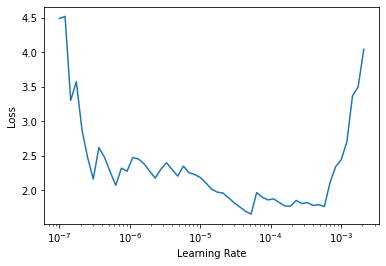

In [17]:
learn.lr_find()

In [16]:
learn.fit_one_cycle(2, 6e-5)

epoch,train_loss,valid_loss,time
0,12.021286,10.987207,11:22
1,7.404379,6.908641,10:54


In [18]:
learn.fit_one_cycle(2, 3e-5)

epoch,train_loss,valid_loss,time
0,6.712125,6.833532,11:04
1,5.689308,5.428658,10:59


In [18]:
learn.fit_one_cycle(2, 2e-5)

epoch,train_loss,valid_loss,time
0,6.282110,6.132824,10:59
1,5.982291,5.493028,10:50


In [19]:
learn.fit(2, 6e-6)

epoch,train_loss,valid_loss,time
0,5.122770,4.999795,10:42
1,4.971440,4.993125,10:38


In [18]:
learn.fit(2, 3e-6)

epoch,train_loss,valid_loss,time
0,4.567326,4.598802,20:11
1,4.942649,4.386112,19:42


In [20]:
learn.fit(2, 2e-6)

epoch,train_loss,valid_loss,time
0,3.600719,5.275278,10:48
1,5.167853,4.749454,10:43


In [22]:
learn.fit(2, 3e-5)

epoch,train_loss,valid_loss,time
0,4.501456,4.827365,11:11
1,5.389635,4.585077,11:08


In [32]:
learn.fit(2, 3e-7)

epoch,train_loss,valid_loss,time
0,4.484249,3.805464,11:52
1,4.181730,3.480850,11:16


In [34]:
learn.fit(2, 1e-7)

epoch,train_loss,valid_loss,time
0,3.619603,3.706990,12:10
1,4.078681,3.584441,12:13


In [38]:
learn.fit_one_cycle(3, 1e-5)

epoch,train_loss,valid_loss,time
0,3.648156,3.868309,11:09
1,3.571895,3.789504,11:02
2,3.433159,3.738166,11:02


In [41]:
learn.fit_one_cycle(3, 4e-6)

epoch,train_loss,valid_loss,time
0,3.784136,4.010053,10:44
1,3.221513,3.863040,11:06
2,3.562761,3.132262,11:09


In [43]:
learn.fit_one_cycle(3, 4e-6)

epoch,train_loss,valid_loss,time
0,3.609633,3.595756,10:39
1,3.933305,3.484798,10:29
2,2.861936,3.264868,10:16


In [45]:
learn.fit_one_cycle(3, 2e-6)

epoch,train_loss,valid_loss,time
0,3.662965,3.861312,11:05
1,3.291039,3.477786,11:01
2,3.353026,2.743589,10:48


In [20]:
learn.fit_one_cycle(3, 1e-6)

epoch,train_loss,valid_loss,time
0,3.313486,3.464383,24:18
1,3.874274,3.135722,24:01
2,3.743514,3.309237,24:55


In [20]:
learn.fit_one_cycle(3, 3e-7)

epoch,train_loss,valid_loss,time
0,3.349173,3.361543,10:40
1,3.640501,3.259936,10:39
2,3.896230,3.038330,10:36


In [44]:
learn.fit_one_cycle(3, 5e-6)

epoch,train_loss,valid_loss,time
0,3.969876,3.598745,11:07
1,3.082333,3.394528,11:04
2,2.910002,2.817010,10:56


In [48]:
learn.fit_one_cycle(3, 2e-5)

epoch,train_loss,valid_loss,time
0,3.356151,3.472061,10:54
1,3.028408,2.996489,10:44
2,2.713071,3.372367,11:00


In [50]:
learn.fit_one_cycle(3, 3e-6)

epoch,train_loss,valid_loss,time
0,2.855273,3.286164,10:41
1,2.660293,3.180092,10:50
2,3.270489,3.016848,10:54


In [52]:
learn.fit_one_cycle(3, 5e-5)

epoch,train_loss,valid_loss,time
0,3.725343,4.420531,11:01
1,3.012385,2.899963,10:52
2,2.307879,2.628317,10:57


In [58]:
learn.fit_one_cycle(3, 3e-5)

epoch,train_loss,valid_loss,time
0,3.463927,2.990889,11:33
1,2.464830,2.589424,11:26
2,2.210540,2.853473,11:13


In [60]:
learn.fit_one_cycle(3, 2e-5)

epoch,train_loss,valid_loss,time
0,2.335787,2.671042,10:55
1,2.272031,2.243389,11:00
2,2.270762,2.302779,11:05


In [64]:
learn.fit_one_cycle(3, 1e-5)

epoch,train_loss,valid_loss,time
0,2.587870,2.448438,10:57
1,1.908936,2.462976,11:10
2,2.095883,2.257174,11:14


In [19]:
learn.fit_one_cycle(3, 2e-6)

epoch,train_loss,valid_loss,time
0,2.372940,2.056555,10:40
1,2.012444,1.864491,11:14
2,2.035535,2.031913,11:27


In [20]:
learn.fit_one_cycle(3, 1e-6)

epoch,train_loss,valid_loss,time
0,2.014152,2.121170,11:26
1,1.955325,2.295633,11:24
2,2.067038,2.282102,11:33


In [22]:
learn.fit_one_cycle(3, 1.5e-6)

epoch,train_loss,valid_loss,time
0,1.800185,2.032683,10:31
1,1.726404,2.060774,10:33
2,1.868509,1.962369,10:35


In [27]:
learn.fit_one_cycle(3, 2e-5)

epoch,train_loss,valid_loss,time
0,2.202704,2.329217,10:39
1,2.065837,1.898698,11:45
2,1.751642,2.200478,11:34


In [18]:
learn.fit_one_cycle(3, 3e-5)

epoch,train_loss,valid_loss,time
0,2.411918,2.336329,21:11
1,2.191268,1.991500,22:08
2,1.752716,2.184080,20:57


In [37]:
# From old stuffs
learn.fit_one_cycle(2, 6e-5)

epoch,train_loss,valid_loss,time
0,3.836380,2.780645,07:32
1,3.809782,2.940755,07:32


In [39]:
running_train_losses = torch.stack(copy(learn.recorder.losses))
full_train_losses.append(running_train_losses)

In [40]:
with open('full_train_losses.pkl', 'wb') as f:
    pickle.dump(full_train_losses, f, protocol=pickle.HIGHEST_PROTOCOL)

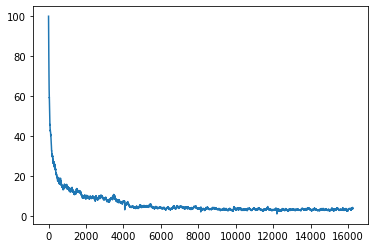

In [41]:
grand_train_losses = torch.cat(full_train_losses, dim=0)
plt.plot(grand_train_losses)

In [36]:
xx, yy = dls.one_batch()

In [39]:
xx.min()

TensorBase(-0.9988, device='cuda:0')

In [37]:
%%timeit
learn.model(xx)

51.2 ms ± 1.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [126]:
xx, yy = learn.dls.valid.one_batch()
xx = xx.to(device)
# learn.model(xx.to(device))

In [19]:
learn.dls.valid.shuffle = True

In [26]:
from sklearn.manifold import TSNE

def show_pca_results(learnr, ds='valid', dim=3, method='tsne', Q_override=None):
    old_bs = learn.dls.bs
    if ds == 'valid':
        xx, yy = learnr.dls.valid.one_batch()
    else:
        xx, yy = learnr.dls.train.one_batch()
    learn.dls.bs = old_bs
    #xx, yy = learn.dls.one_batch()
    learnr.model.eval()
    with torch.no_grad(): 
        print(xx.shape)
        pred = learnr.model(xx.to(device))
        if len(pred) == 2: pred = pred[1]
        pred = pred.view(-1, 256)
        print(pred.shape)
        #pred = pred / torch.norm(pred, dim=1).unsqueeze(1)
    if method == 'tsne':
        tsmod = TSNE(n_components=dim, perplexity=5, metric='cosine')
        x_proj = tsmod.fit_transform(pred.cpu().numpy())
        mult = x_proj.shape[0]
        bs = mult//MelSpecGroup.n_uttr
        proj = x_proj.reshape(bs, MelSpecGroup.n_uttr, -1)
    else:
        means = pred.T.mean(dim=-1)[:, None]
        u, s, vh = torch.svd(pred.T - means, some=True)
        Q = u[:, :dim]
        if Q_override is not None:
            Q = Q_override[:, :dim].clone().to(device)
        pca_proj = (Q.T@(pred.T - means)).T
        mult = pca_proj.shape[0]
        bs = mult//MelSpecGroup.n_uttr
        proj = pca_proj.view(bs, MelSpecGroup.n_uttr, -1).cpu().numpy()
    fig = plt.figure(figsize=(14, 8))
    if dim == 3:
        ax = fig.add_subplot(111, projection='3d')
    else:
        ax = fig.add_subplot(111)
    print(yy)
    for spk in proj:
        
        if dim == 3:
            ax.scatter(spk[:, 0], spk[:, 1], spk[:, 2])
        else:
            ax.scatter(spk[:, 0], spk[:, 1])
    ax.legend([spk_names[int(t)] for t in yy])
    ax.grid(True)
    #ax.set_title(f"{method} projection of one test batch of utterance embeddings, colored by speaker")
    ax.set_xlabel("1st principal component", fontsize=18)
    ax.set_ylabel("2nd principal component", fontsize=18)
    if dim == 3: ax.set_zlabel("3rd principal component")
    fig.tight_layout()
    return proj

In [19]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

(8, 6, 80, 115)
torch.Size([48, 256])
TensorCategory([10842, 10992,  6815,  3729,  7021,   874,  9568,  1443],
       device='cuda:0', dtype=torch.int32)


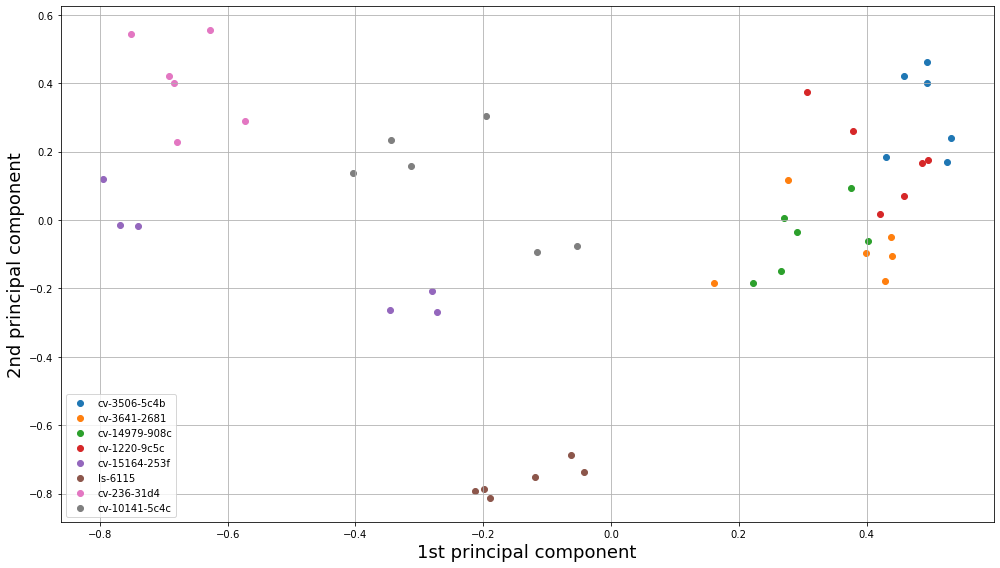

In [21]:
s = show_pca_results(learn, 'valid', 2, 'pca')
# plt.savefig('ge2e_pca.eps', transparent=False)

(8, 6, 80, 250)
torch.Size([48, 256])
TensorCategory([10842, 10992,  6815,  3729,  7021,   874,  9568,  1443],
       device='cuda:0', dtype=torch.int32)


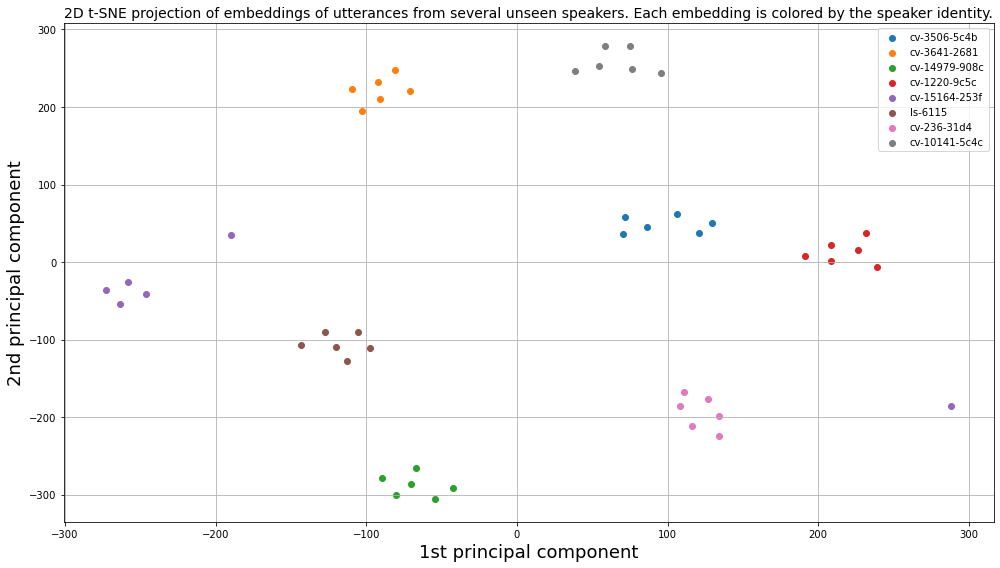

In [35]:
s = show_pca_results(learn, 'valid', 2, 'tsne')
plt.title("2D t-SNE projection of embeddings of utterances from several unseen speakers. Each embedding is colored by the speaker identity.", fontsize=14)
plt.tight_layout()
plt.savefig('tsne-embedding.svg', transparent=False)

## Saving model for inference

In [20]:
enc = learn.model.encoder
enc.rnn_stack.flatten_parameters()
torch.save(enc.state_dict(), './weights/gru-big.pth')

In [22]:
enc.state_dict()

odict_keys(['rnn_stack.weight_ih_l0', 'rnn_stack.weight_hh_l0', 'rnn_stack.bias_ih_l0', 'rnn_stack.bias_hh_l0', 'rnn_stack.weight_ih_l1', 'rnn_stack.weight_hh_l1', 'rnn_stack.bias_ih_l1', 'rnn_stack.bias_hh_l1', 'rnn_stack.weight_ih_l2', 'rnn_stack.weight_hh_l2', 'rnn_stack.bias_ih_l2', 'rnn_stack.bias_hh_l2', 'projection.weight', 'projection.bias'])